[README.md](https://github.com/open-mmlab/mmsegmentation)

## Install MMSegmentation
This step may take several minutes.

We use PyTorch 1.10 and CUDA 11.1 for this tutorial. You may install other versions by change the version number in pip install command.

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



**Step 0.** Install MMCV using MIM.

In [ ]:
!pip install -U openmim
!mim install mmengine
!mim install "mmcv>=2.0.0"

# Restart runtime

Step 1. Install MMSegmentation.

Case a: If you develop and run mmseg directly, install it from source:

In [ ]:
!git clone -b main https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation
!pip install -v -e .
# '-v' means verbose, or more output
# '-e' means installing a project in editable mode,
# thus any local modifications made to the code will take effect without reinstallation.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Play around with COCO

In [3]:
%cd ~/
%mkdir /content/mmsegmentation/data
%cd /content/mmsegmentation/data

/root
/content/mmsegmentation/data


In [5]:
# copy config we will use
%mkdir /content/mmsegmentation/configs/custom
%cp -r /content/drive/MyDrive/segmentations/configs/*.py /content/mmsegmentation/configs/custom

In [6]:
# copy dataset file
%cp -r /content/drive/MyDrive/segmentations/datasets/*.py /content/mmsegmentation/mmseg/datasets

In [ ]:
# # download
# %mkdir coco_stuff10k
# %cd coco_stuff10k
# !wget http://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/cocostuff-10k-v1.1.zip

# # unzip
# !unzip cocostuff-10k-v1.1.zip

# process it
# !python /content/mmsegmentation/tools/dataset_converters/coco_stuff10k.py /content/mmsegmentation/data/coco_stuff10k --nproc 8 -o /content/mmsegmentation/data/coco/

- Bring custom voc config file where the followings are changed
    - `data_root`
    - the number of classes has been changed

## Dataset Registration

- mmseg/datasets
    - add coco_custom.py
- mmseg/datasets/init
    - from .coco_custom import COCOCustomDataset
    - add it to the __all__

- **always check alignment with config file**


## Data Sanity

In [ ]:
import os
import numpy as np

train_imgs = os.listdir('/content/drive/MyDrive/segmentations/data/coco/images/train2014')
train_labels = os.listdir('/content/drive/MyDrive/segmentations/data/coco/annotations/train2014')

img exists, but label does not

In [ ]:
not_labeled_imgs = np.unique(np.array([0 if img in train_labels else idx for idx, img in enumerate(train_imgs)]))
not_labeled_imgs

array([0])

label exists but img does not

In [ ]:
not_imaged_labels = np.unique(np.array([0 if img in train_imgs else idx for idx, img in enumerate(train_labels)]))
not_imaged_labels

array([0])

according to the result, two imgs need to be deleted

In [ ]:
for del_this in not_labeled_imgs[1:]:
    name = None
    name = train_imgs[del_this]

    path_del = os.path.join('/content/drive/MyDrive/segmentations/data/coco/images/train2014', name)
    os.remove(path_del)

## Some settings before train

### In Directory
- dataset file
- init file in datasets

### In configuration

|Type|item2|item3|item4|
|-----|-----|-----|-----|
|Data:|data_root|data_prefix|dataset type|
|Misc:|num_classes|reduce_zero_label|$$-$$|
|iters/interval|scheduler|hook|train_cfg|

In [ ]:
!python /content/mmsegmentation/tools/train.py /content/mmsegmentation/configs/custom/swin_binary_organized.py


10/06 20:22:30 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/swin/swin_tiny_patch4_window7_224_20220317-1cdeb081.pth
Downloading: "https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/swin/swin_tiny_patch4_window7_224_20220317-1cdeb081.pth" to /root/.cache/torch/hub/checkpoints/swin_tiny_patch4_window7_224_20220317-1cdeb081.pth
100% 106M/106M [00:01<00:00, 64.1MB/s]
10/06 20:22:33 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/06 20:22:33 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
10/06 20:22:33 - mmengine - INFO - Checkpoints will be saved to /content/mmsegmentation/data/work_dirs/swin-tiny-patch4-window7-in1k-pre_upernet_8xb2-160k_ade20k-512x512.
10/06 20:23:03 - 

In [ ]:
# # copy .pth files
# %cp -r /content/mmsegmentation/data/work_dirs/swin-tiny-patch4-window7-in1k-pre_upernet_8xb2-160k_ade20k-512x512/iter_2000.pth /content/drive/MyDrive/segmentations/checkpoints/swin/2000.pth

# # config
# %cp -r /content/mmsegmentation/configs/custom/swin_binary_organized.py /content/drive/MyDrive/segmentations/checkpoints/swin/

### We can train again using pre-trained weights

Sample
```bash
!python /content/mmsegmentation/tools/train.py \
        /content/mmsegmentation/configs/custom/swin_binary_organized.py \
        --cfg-options load_from=/content/drive/MyDrive/segmentations/checkpoints/swin/2000.pth
```
If you were disturbed, utilize `resume` config.

``` bash
!python /content/mmsegmentation/tools/train.py \
        /content/mmsegmentation/configs/custom/swin_binary_organized.py \
        --resume \
        --cfg-options load_from=/content/drive/MyDrive/segmentations/checkpoints/swin/2000.pth
```

In [ ]:
# !python /content/mmsegmentation/tools/train.py /content/mmsegmentation/configs/custom/swin_binary_organized.py --cfg-options load_from=/content/drive/MyDrive/segmentations/checkpoints/swin/2000.pth

In [ ]:
# !python /content/mmsegmentation/tools/train.py /content/mmsegmentation/configs/custom/swin_binary_losses.py --cfg-options load_from=/content/drive/MyDrive/segmentations/checkpoints/swin/4000.pth

10/06 21:07:42 - mmengine - INFO - Iter(train) [  50/2000]  base_lr: 5.8918e-06 lr: 5.8918e-06  eta: 0:11:22  time: 0.2008  data_time: 0.0071  memory: 10661  loss: 0.2281  decode.loss_dice: 0.0619  decode.loss_focal: 0.0145  decode.acc_seg: 96.3686  aux.loss_dice: 0.1307  aux.loss_focal: 0.0210  aux.acc_seg: 94.2610
10/06 21:07:52 - mmengine - INFO - Iter(train) [ 100/2000]  base_lr: 1.1904e-05 lr: 1.1904e-05  eta: 0:08:45  time: 0.2039  data_time: 0.0072  memory: 3812  loss: 0.3451  decode.loss_dice: 0.0909  decode.loss_focal: 0.0283  decode.acc_seg: 94.3289  aux.loss_dice: 0.1878  aux.loss_focal: 0.0381  aux.acc_seg: 93.1400
10/06 21:08:02 - mmengine - INFO - Iter(train) [ 150/2000]  base_lr: 1.7916e-05 lr: 1.7916e-05  eta: 0:07:46  time: 0.2007  data_time: 0.0069  memory: 3812  loss: 0.3034  decode.loss_dice: 0.0847  decode.loss_focal: 0.0226  decode.acc_seg: 96.7932  aux.loss_dice: 0.1693  aux.loss_focal: 0.0269  aux.acc_seg: 95.3613
10/06 21:08:12 - mmengine - INFO - Iter(train) [

In [ ]:
# # copy .pth files
# %cp -r /content/mmsegmentation/work_dirs/swin-tiny-patch4-window7-in1k-pre_upernet_8xb2-160k_ade20k-512x512/iter_6000.pth /content/drive/MyDrive/segmentations/checkpoints/swin/6000.pth

# # config
# %cp -r /content/mmsegmentation/work_dirs/swin-tiny-patch4-window7-in1k-pre_upernet_8xb2-160k_ade20k-512x512/20231006_210717/vis_data/config.py /content/drive/MyDrive/segmentations/checkpoints/swin/config_4000-6000.py

# Inference

In [7]:
%cd /content/mmsegmentation

/content/mmsegmentation


/content/mmsegmentation/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/content/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '


Loads checkpoint by local backend from path: /content/drive/MyDrive/segmentations/checkpoints/swin/2000.pth


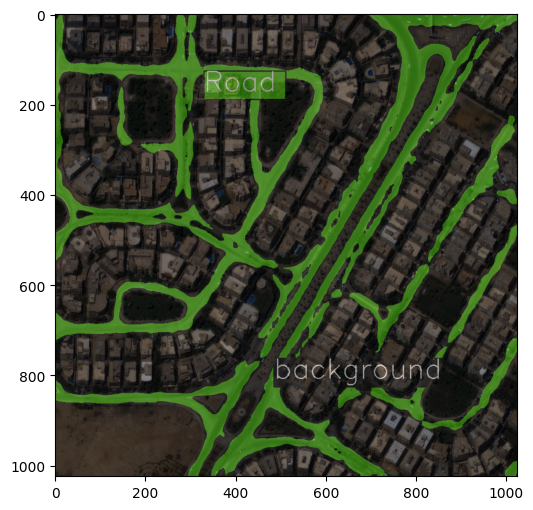

In [9]:
from mmseg.apis import init_model, inference_model, show_result_pyplot
from mmengine import Config

import mmcv
import matplotlib.pyplot as plt

# Init the model from the config and the checkpoint
dir_work = '/content/mmsegmentation/data/work_dirs'
model_name = 'swin-tiny-patch4-window7-in1k-pre_upernet_8xb2-160k_ade20k-512x512'

checkpoint_path = '/content/drive/MyDrive/segmentations/checkpoints/swin/2000.pth'

cfg = Config.fromfile('/content/mmsegmentation/configs/custom/swin_binary.py')


model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread('/content/drive/MyDrive/segmentations/data/coco/images/test2014/BLD00097_PS3_K3A_NIA0276.png')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))

In [10]:
import mmcv
import matplotlib.pyplot as plt

import cv2
from PIL import Image

from mmengine import Config
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = '/content/drive/MyDrive/segmentations/checkpoints/swin/6000.pth'
cfg = Config.fromfile('/content/mmsegmentation/configs/custom/swin_binary.py')

model = init_model(cfg, checkpoint_path, 'cuda:0')

Loads checkpoint by local backend from path: /content/drive/MyDrive/segmentations/checkpoints/swin/6000.pth


<Figure size 800x600 with 0 Axes>

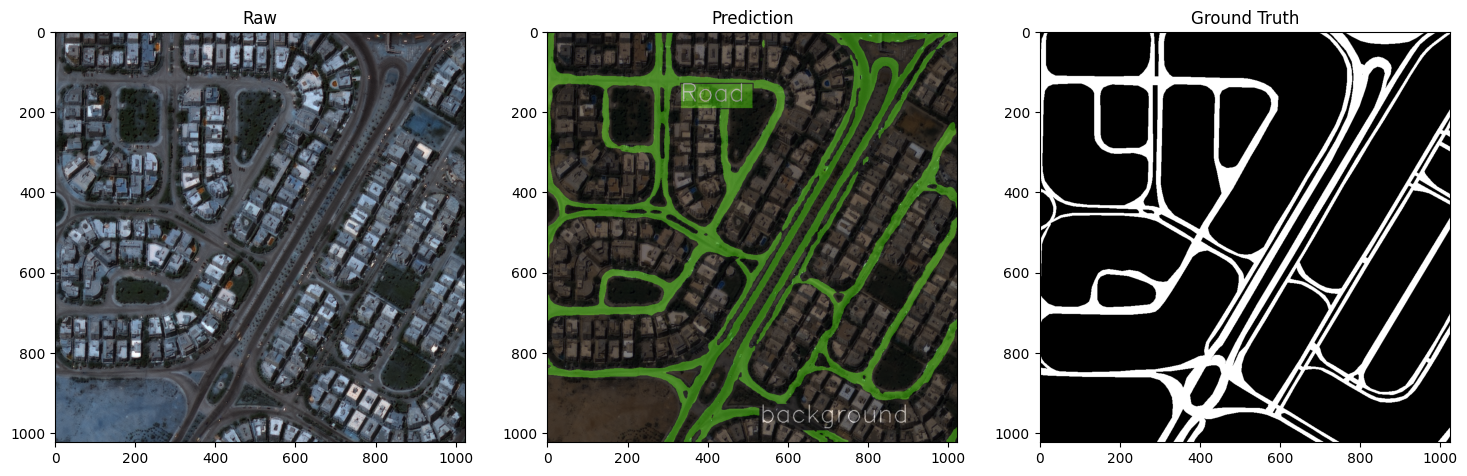

In [11]:
# Model Result
img = mmcv.imread('/content/drive/MyDrive/segmentations/data/coco/images/test2014/BLD00097_PS3_K3A_NIA0276.png')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)

# plt.imshow(mmcv.bgr2rgb(vis_result))

# Ground Truth
gt_mask = cv2.imread('/content/drive/MyDrive/segmentations/data/coco/annotations/test2014/BLD00097_PS3_K3A_NIA0276.png')
gt_mask = Image.fromarray(gt_mask*255) #.resize((512, 512))


fig, axs = plt.subplots(1, 3, figsize=(18, 18))
axs[0].imshow(img)
axs[0].set_title('Raw')

axs[1].imshow(mmcv.bgr2rgb(vis_result))
axs[1].set_title('Prediction')

axs[2].imshow(gt_mask)
axs[2].set_title('Ground Truth')
plt.show()

## To-do
- Smooth transition between backbone/auxiliary/decoder < consider shapes?


## Explored
- Combination of losses
- resume & load_from
- custom transformation

## Explore Dataset

In [17]:
%cd /content/mmsegmentation/mmseg

/content/mmsegmentation/mmseg


In [1]:
from mmseg.datasets.coco_custom_binary import COCOCustomBiDataset
from mmengine.registry import init_default_scope
init_default_scope('mmseg')

data_root = '/content/drive/MyDrive/segmentations/data/coco'
data_prefix=dict(img_path='images/train2014', seg_map_path='annotations/train2014')
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomCrop', crop_size=(512, 1024), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

dataset = COCOCustomBiDataset(data_root=data_root, data_prefix=data_prefix, test_mode=False, pipeline=train_pipeline)

In [2]:
len(dataset)

1143

In [3]:
dataset.get_data_info(1)

{'img_path': '/content/drive/MyDrive/segmentations/data/coco/images/train2014/BLD00003_PS3_K3A_NIA0276.png',
 'seg_map_path': '/content/drive/MyDrive/segmentations/data/coco/annotations/train2014/BLD00003_PS3_K3A_NIA0276.png',
 'label_map': None,
 'reduce_zero_label': False,
 'seg_fields': [],
 'sample_idx': 1}

In [4]:
dataset.metainfo

{'classes': ('background', 'Road'),
 'palette': [[0, 0, 0], [0, 192, 64]],
 'label_map': None,
 'reduce_zero_label': False}

In [5]:
dataset[0]

{'inputs': tensor([[[ 91,  85,  77,  ..., 114, 126, 143],
          [ 84,  82,  79,  ..., 112, 121, 148],
          [ 80,  85,  83,  ..., 109, 114, 141],
          ...,
          [ 54,  49,  63,  ..., 106,  99,  91],
          [ 52,  45,  50,  ...,  95,  98,  96],
          [ 49,  51,  51,  ...,  84, 104, 100]],
 
         [[ 96,  92,  84,  ..., 147, 148, 141],
          [ 90,  89,  86,  ..., 146, 148, 152],
          [ 86,  91,  89,  ..., 143, 145, 153],
          ...,
          [ 52,  49,  60,  ..., 109, 108, 103],
          [ 49,  46,  51,  ...,  99, 106, 107],
          [ 47,  50,  51,  ...,  88, 110, 111]],
 
         [[102,  99,  91,  ..., 168, 169, 163],
          [ 97,  96,  92,  ..., 166, 169, 174],
          [ 92,  97,  95,  ..., 163, 165, 174],
          ...,
          [ 54,  52,  62,  ..., 118, 120, 117],
          [ 51,  49,  54,  ..., 108, 118, 121],
          [ 48,  52,  54,  ...,  99, 123, 127]]], dtype=torch.uint8),
 'data_samples': <SegDataSample(
 
     META INFORMAT

In [6]:
dataset[0]['inputs']

tensor([[[119, 120, 123,  ...,  87,  83,  66],
         [117, 117, 122,  ...,  82,  75,  82],
         [118, 118, 119,  ...,  78,  73,  72],
         ...,
         [ 94,  90, 110,  ...,  49,  48,  44],
         [104,  80, 101,  ...,  50,  46,  47],
         [118,  88,  98,  ...,  46,  46,  44]],

        [[147, 152, 156,  ...,  92,  87,  72],
         [148, 149, 155,  ...,  87,  80,  83],
         [150, 150, 153,  ...,  84,  77,  74],
         ...,
         [117, 106, 115,  ...,  48,  46,  41],
         [131, 103, 113,  ...,  47,  43,  42],
         [149, 113, 115,  ...,  44,  42,  39]],

        [[164, 170, 174,  ...,  97,  93,  78],
         [164, 166, 172,  ...,  93,  85,  87],
         [167, 166, 169,  ...,  90,  83,  79],
         ...,
         [137, 125, 131,  ...,  50,  47,  42],
         [154, 124, 131,  ...,  49,  44,  43],
         [174, 137, 136,  ...,  45,  43,  40]]], dtype=torch.uint8)

In [7]:
mask = dataset[0]['data_samples'].get('gt_sem_seg').get('data').numpy()
mask

array([[[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]]])

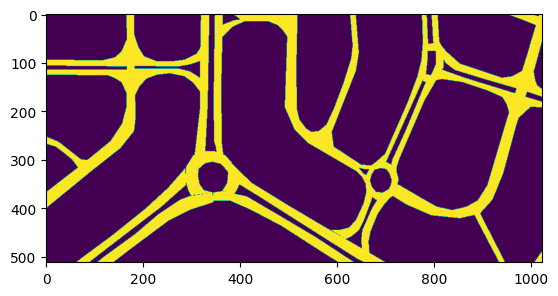

In [9]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

mask_img = Image.fromarray(mask[0].astype(np.uint8)*255)
plt.imshow(mask_img)

## Custom Transformation/Augmentation
- Following code can be used in interactive environments such as Jupyter Notebook.
- In a situation where we directly utilize config file,
    - just add the class using `@TRANSFORM.register_module()` in the TRANSFORM.py
    - or change config file to refer to the class and directly use it.

In [11]:
from mmseg.datasets.coco_custom_binary import COCOCustomBiDataset
from mmengine.registry import init_default_scope
init_default_scope('mmseg')

from mmcv.transforms.base import BaseTransform
from mmseg.registry import TRANSFORMS

@TRANSFORMS.register_module()
class MyChange(BaseTransform):

    """Change source values in segmentation mask to target value"""
    def __init__(self, src=1, tar=3):
        super().__init__()
        self.src = src
        self.tar = tar

    def fillBlank(self, img, src, tar):
        # find source values and convert them into target
        img[img==src]=tar
        return img

    def transform(self, results: dict) -> dict:
        # For Image File
        # img = results['img']
        # results['img'] = mmcv.imflip(img, direction=self.direction)

        # For Segmentation Mask
        for key in results.get('seg_fields', []):
            gt_seg = self.fillBlank(
                img = results[key],
                src = self.src,
                tar = self.tar)

            results[key] = gt_seg

        return results

In [ ]:
data_root = '/content/drive/MyDrive/segmentations/data/coco'
data_prefix=dict(img_path='images/train2014', seg_map_path='annotations/train2014')

train_pipeline = [
    # Load images and masks
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),

    # Apply augmentations
    dict(type='RandomCrop', crop_size=(512, 1024), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='MyChange', src=1, tar=3),

    # Prepare to be used for a model
    dict(type='PackSegInputs')
    ]


dataset2 = COCOCustomBiDataset(
    data_root=data_root,
    data_prefix=data_prefix,
    test_mode=False,
    pipeline=train_pipeline)


In [12]:
# Check Mask
mask = dataset2[0]['data_samples'].get('gt_sem_seg').get('data').numpy()
mask

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [3, 3, 3, ..., 0, 0, 0],
        [3, 3, 3, ..., 0, 0, 0],
        [3, 3, 3, ..., 0, 0, 0]]])